#Dataset Downloading & Unziping

In [1]:
import os
!pip install kaggle -q
os.environ['KAGGLE_USERNAME'] = "saikowndinya"
os.environ['KAGGLE_KEY'] = "de0e780aef58aa3ea09e05bc35e9c9da"
!kaggle datasets download "gunavenkatdoddi/eye-diseases-classification"

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0


In [2]:
!unzip -q eye-diseases-classification.zip

#Importing Libraries

In [3]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import statement
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report

# Data Visualization

In [4]:
labels = ["Normal", "Glaucoma", "Cataract", "Diabetic Retinopathy"]
counts = [1074,1007, 1038, 1098]

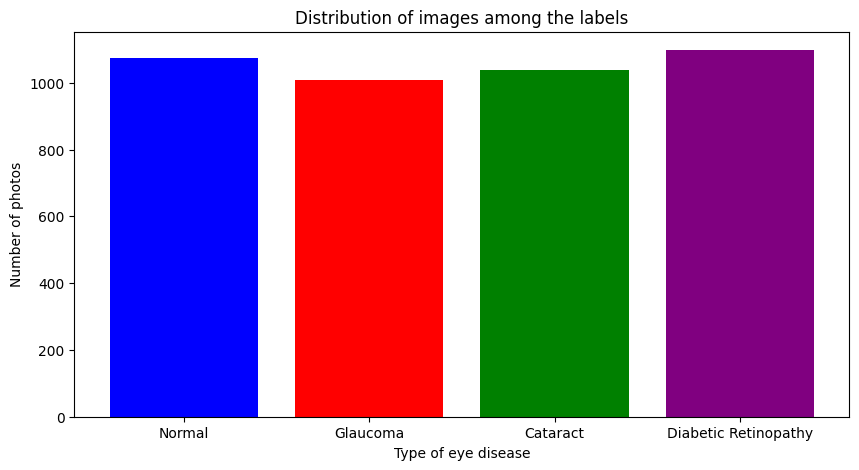

In [5]:
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color=['blue', 'red', 'green', 'purple'])
plt.xlabel("Type of eye disease")
plt.ylabel("Number of photos")
plt.title("Distribution of images among the labels")
plt.show()

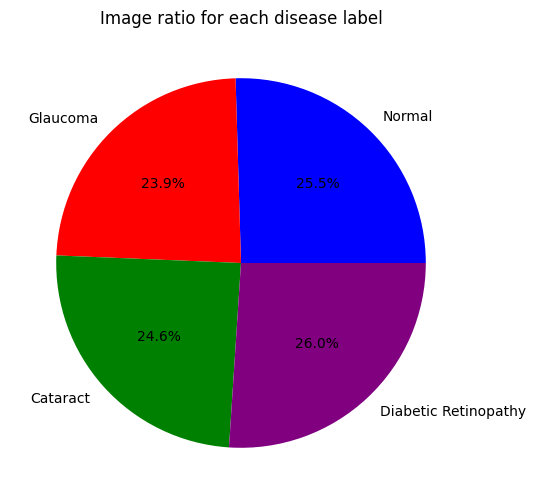

In [6]:
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['blue', 'red', 'green', 'purple'])
plt.title("Image ratio for each disease label")
plt.show()

In [7]:
def visualize_images(path, target_size=(250, 250), num_images=5):
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    selected_images = image_filenames[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')
    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)
    plt.tight_layout()
    plt.show()

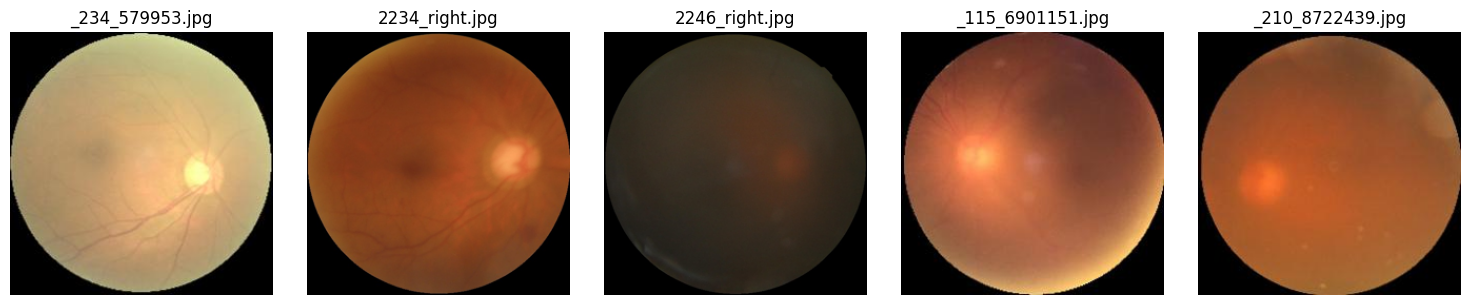

In [8]:
cataract = "/content/dataset/cataract"
visualize_images(cataract, num_images=5)

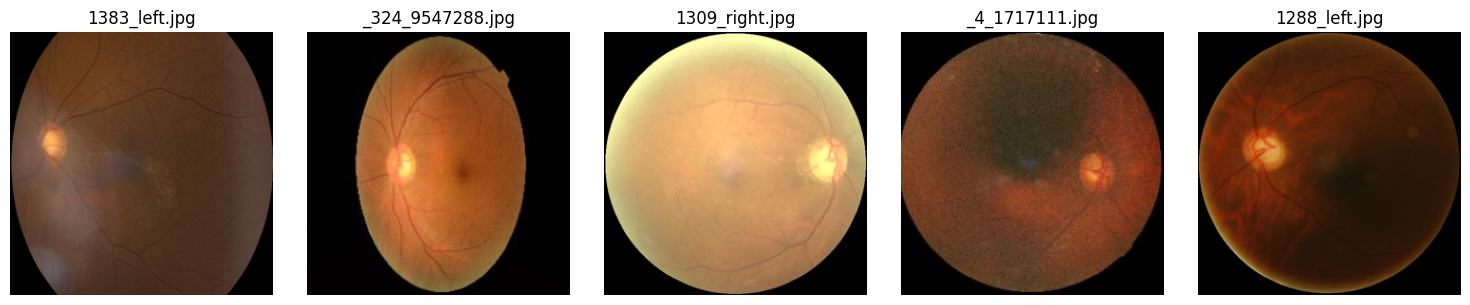

In [9]:
glaucoma = "/content/dataset/glaucoma"
visualize_images(glaucoma, num_images=5)


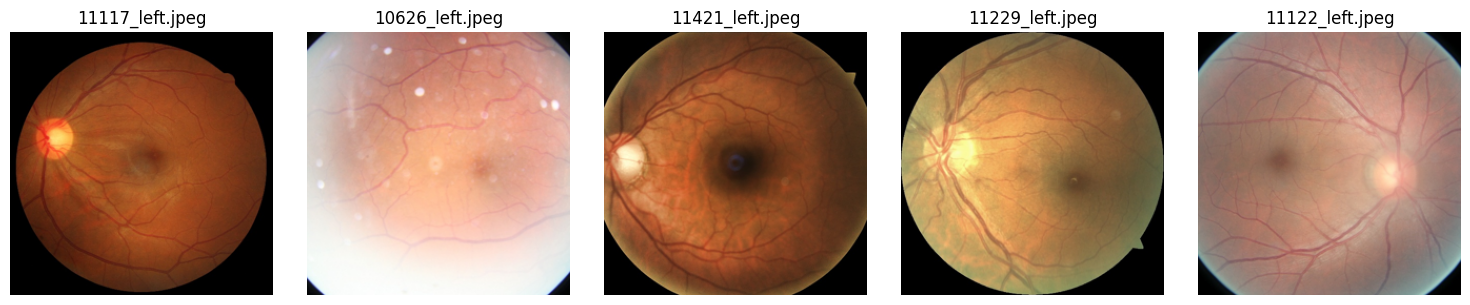

In [10]:
diabetic_retinopathy= "/content/dataset/diabetic_retinopathy"
visualize_images(diabetic_retinopathy, num_images=5)

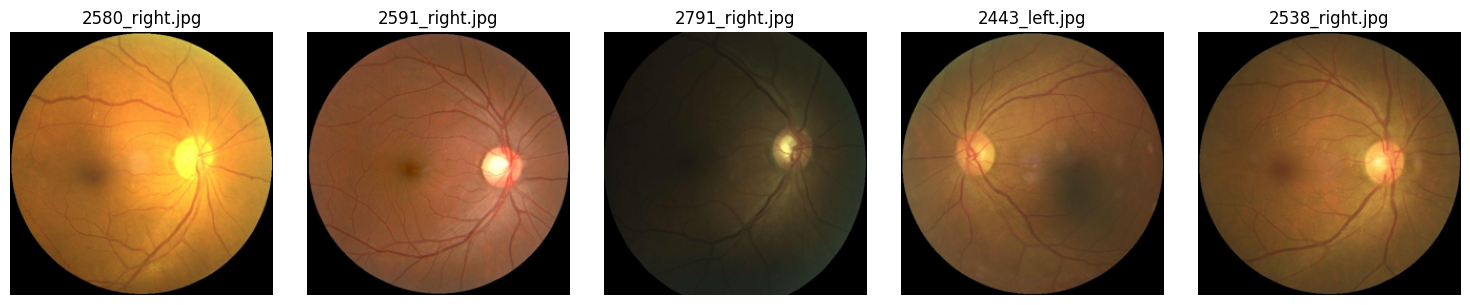

In [11]:
normal= "/content/dataset/normal"
visualize_images(normal, num_images=5)

# Dataset creation

In [12]:
data = "/content/dataset"
rescale = tf.keras.layers.Rescaling(1./255)
# Function to load dataset
def load_dataset(directory, subset=None, validation_split=0.25, batch_size=32, shuffle=True):
    return tf.keras.utils.image_dataset_from_directory(
        directory=directory,
        batch_size=batch_size,
        image_size=(256, 256),
        validation_split=validation_split if subset else None,
        subset=subset,
        seed=123,
        label_mode='categorical',
        shuffle=shuffle
    ).map(lambda x, y: (rescale(x), y))
train_ds = load_dataset(data, subset="training")
validation_ds = load_dataset(data, subset="validation")

Found 4217 files belonging to 4 classes.
Using 3163 files for training.
Found 4217 files belonging to 4 classes.
Using 1054 files for validation.


# Model Creation And Training

In [13]:
model = keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)),

    tf.keras.layers.Conv2D(32, (5, 5), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="valid"),
    tf.keras.layers.Conv2D(64, (1, 1), activation="relu", padding="valid"),
    tf.keras.layers.Conv2D(128, (1, 1), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    #tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4, activation="softmax")
])

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,575,780 (112.82 MB)

 Trainable params: 29,575,652 (112.82 MB)

 Non-trainable params: 128 (512.00 B)

None


In [16]:
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping("val_accuracy", patience=5, verbose=1),
                        tf.keras.callbacks.ModelCheckpoint("Best model.keras", monitor="val_accuracy", save_best_only=True)
                    ],
                    epochs=50)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 270ms/step - accuracy: 0.4803 - loss: 2.8500 - val_accuracy: 0.2998 - val_loss: 1.3303
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.7370 - loss: 0.6173 - val_accuracy: 0.5588 - val_loss: 1.0499
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.7849 - loss: 0.5121 - val_accuracy: 0.5522 - val_loss: 0.9643
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.8323 - loss: 0.4185 - val_accuracy: 0.4934 - val_loss: 1.2578
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - accuracy: 0.8505 - loss: 0.3827 - val_accuracy: 0.5114 - val_loss: 1.0794
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 233ms/step - accuracy: 0.8670 - loss: 0.3440 - val_accuracy: 0.6471 - val_loss: 0.8129
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 205ms/step - accuracy: 0.8723 - loss: 0.3192 - val_accuracy: 0.8567 - val_loss: 0.3705
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 171ms/step - accuracy: 0.9095 - loss: 0.2484 - val_accu

In [17]:
model.save('Final eye_disease_model.keras')

# Loading best model

In [18]:
!sha256sum "Best model1.keras"

sha256sum: 'Best model1.keras': No such file or directory


In [19]:
best_model = tf.keras.models.load_model("Best model.keras")

In [20]:
best_model.evaluate(validation_ds, return_dict=True)

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8611 - loss: 0.3275


{'accuracy': 0.8567362427711487, 'loss': 0.3704996109008789}

In [21]:
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=99>


#Prediction #

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
Raw Predictions: [[1.1212769e-05 9.9898690e-01 4.5209358e-04 5.4981495e-04]]
Predicted Class: Diabetic Retinopathy
Confidence: 99.90


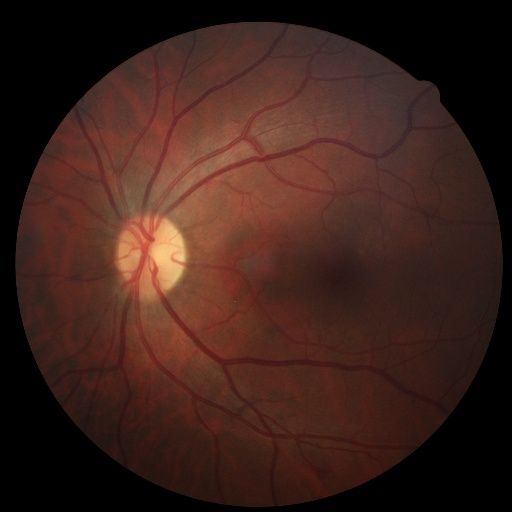

In [24]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/Best model.keras")  # Ensure correct model path

# Class labels
class_labels = ["Cataract", "Diabetic Retinopathy", "Glaucoma", "Normal Image"]

def predict_image(image_path):
    """Predicts the class of an input image."""
    img = tf.keras.utils.load_img(image_path, target_size=(256, 256))
    img = tf.keras.utils.img_to_array(img, dtype=np.float64) / 255.0
    predictions = model.predict(np.array([img]))

    # Print raw predictions for debugging
    print(f"Raw Predictions: {predictions}")

    class_index = np.argmax(predictions)  # Get the highest probability index
    return class_labels[class_index], np.max(predictions)

# Example usage
image_path ="/content/dataset/diabetic_retinopathy/10069_left.jpeg"  # Replace with actual image path
result, confidence = predict_image(image_path)
print(f"Predicted Class: {result}\nConfidence: {confidence * 100:.2f}")

tf.keras.utils.load_img(image_path)
